In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import glob
%matplotlib inline

# PLANS

In [28]:
def permutations(array, n=None, perm=[]):
    if n == None:
        n = len(array)
    if n == 0:
        yield perm
    else:
        for i in range(len(array)):
            yield from permutations(array[:i] + array[i + 1:], n - 1,
                                    perm + [array[i]])
def all_plans():
    yield from permutations(list(range(5)), 3)


PLANS = list(all_plans())
COLORS = np.array([[0, 124, 176], [208, 93, 40], [14, 14, 16], [97, 153, 59],
          [247, 181, 0]], dtype=np.uint8)
LABELS = ['blue', 'orange', 'black', 'green', 'yellow']

In [8]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

def eulerAnglesToRotationMatrix(theta):
    R_x = np.array([[1, 0, 0], [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]),
                     np.cos(theta[0])]])
    R_y = np.array([[np.cos(theta[1]), 0,
                     np.sin(theta[1])], [0, 1, 0],
                    [-np.sin(theta[1]), 0,
                     np.cos(theta[1])]])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0], [0, 0, 1]])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R


def get_camera_matrix(f, pixel_size, img_size, rotation_matrix,
                      camera_position):
    H = np.array([[f / pixel_size, 0, img_size[0] / 2],
                  [0, f / pixel_size, img_size[1] / 2], [0, 0, 1]])
    t = -rotation_matrix.dot(camera_position)
    M = np.concatenate((rotation_matrix, t), axis=1)
    return H.dot(M)

ImportError: No module named 'colormath'

# Show image

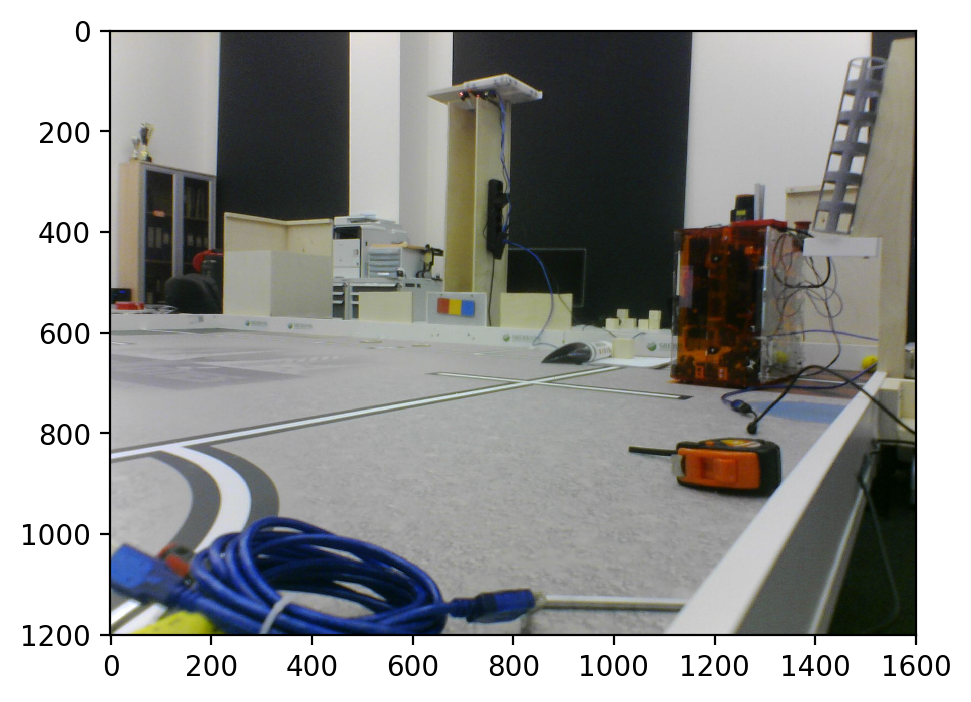

In [9]:
img = cv2.imread("imgs/140.png") 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR));

# Projection transformation using specific matrix

In [47]:
img_points = np.float32([(743, 590), (744, 527), (860, 528), (861, 596)])
h_border = 60 * 3
w_border = 60 * 20
h_rect = 130
w_rect = 300
dw = (w_border - w_rect) / 2
dh = (h_border - h_rect) / 2
real_points = np.float32([(dw, h_border - dh), (dw, dh), 
                          (w_border - dw, dh), (w_border - dw, h_border - dh)])
M = cv2.getPerspectiveTransform(img_points, real_points)

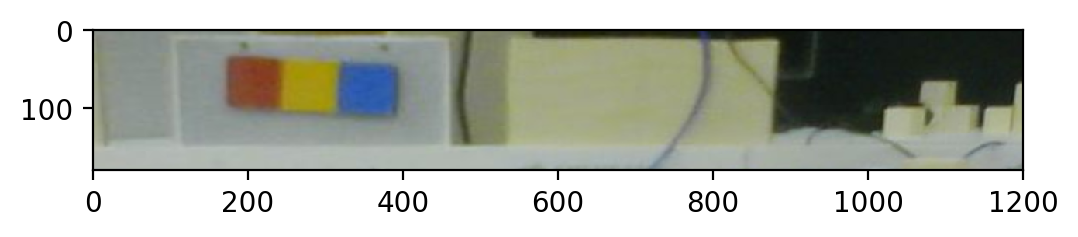

In [48]:
tr_img = cv2.warpPerspective(img, M, (w_border, h_border))
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(cv2.cvtColor(tr_img, cv2.COLOR_RGB2BGR));

# Rough image

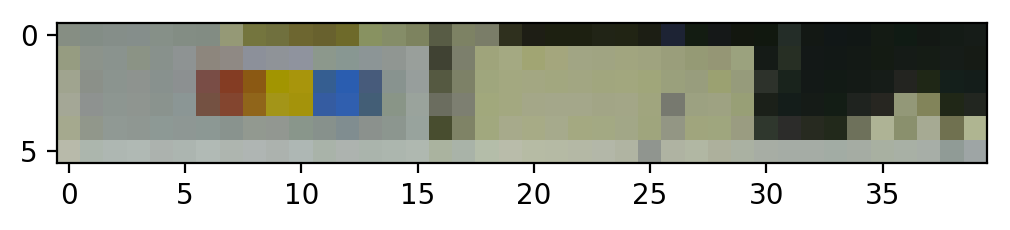

In [62]:
points1 = np.float32([(0, h_border), (0, 0), 
                       (w_border, 0)])
points2 = np.float32([(0, h_border // 30), (0, 0), 
                       (w_border // 30, 0)])

rough_img = cv2.warpAffine(tr_img, cv2.getAffineTransform(points1, points2), 
                    (w_border // 30, h_border // 30))

fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=200)
ax.imshow(cv2.cvtColor(rough_img, cv2.COLOR_RGB2BGR))

# Cube sequence searching

In [131]:
# sv_thr = 120

# hsv_target_colors = cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2HSV)[0]
# hsv_colors = cv2.cvtColor(avg_colors, cv2.COLOR_RGB2HSV)

# dist_array = np.zeros((hsv_colors.shape[0], hsv_colors.shape[1],
#                        hsv_target_colors.shape[0]))
# for i in range(hsv_target_colors.shape[0]):
#     if i == 2:
#         dist_array[:, :, i] = np.where(
#             hsv_colors[:, :, 2] < sv_thr,
#             np.abs(hsv_colors[:, :, 2] - hsv_target_colors[i, 2]), np.inf)
#     else:
#         dist_1 = (hsv_colors[:, :, 0] - hsv_target_colors[i, 0]) % 255
#         dist_2 = (hsv_target_colors[i, 0] - hsv_colors[:, :, 0]) % 255
#         dist_h = np.where(dist_1 < dist_2, dist_1, dist_2)
#         dist_array[:, :, i] = np.where(
#             (hsv_colors[:, :, 2] > 3 * hsv_target_colors[i, 2] / 4) *
#             (hsv_colors[:, :, 1] > 3 * hsv_target_colors[i, 1] / 4), dist_h,
#             np.inf)

# plan_dist_array = np.zeros((hsv_colors.shape[0] - 4, hsv_colors.shape[1],
#                             len(PLANS)))

# for i, plan in enumerate(PLANS):
#     plan_dist_array[:, :, i] = sum([
#         np.roll(dist_array[:, :, plan[x]], -2 * x, axis=0)[:-4, :]
#         for x in range(3)
#     ])

# best_plan = np.unravel_index(
#     np.argmin(plan_dist_array), (hsv_colors.shape[0] - 4, hsv_colors.shape[1],
#                                  len(PLANS)))[2]
# [LABELS[PLANS[best_plan][x]] for x in range(3)]

In [205]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

def color_distance(c1, c2):
    color1 = sRGBColor(*c1, is_upscaled=True)
    lab_color1 = convert_color(color1, LabColor)
    color2 = sRGBColor(*c2, is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    return delta_e_cmc(lab_color1, lab_color2)

In [206]:
lab_target_colors = np.array(
    cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2LAB)[0], dtype=np.int32)
lab_colors = np.array(
    cv2.cvtColor(avg_colors, cv2.COLOR_RGB2LAB), dtype=np.int32)

# dist_array = np.zeros((lab_colors.shape[0], lab_colors.shape[1],
#                        lab_target_colors.shape[0]))

# for i in range(lab_target_colors.shape[0]):
#     dist_array[:, :, i] = np.sum(
#         (lab_colors - lab_target_colors[i, :]) ** 2, axis=2) **0.5

# plan_dist_array = np.zeros((lab_colors.shape[0] - 4, lab_colors.shape[1],
#                             len(PLANS)))

# for i, plan in enumerate(PLANS):
#     plan_dist_array[:, :, i] = sum([
#         np.roll(dist_array[:, :, plan[x]], -2 * x, axis=0)[:-4, :]
#         for x in range(3)
#     ])

# best_plan = np.unravel_index(
#     np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
#                                  len(PLANS)))[2]
# [LABELS[PLANS[best_plan][x]] for x in range(3)]

In [207]:
dist_array = np.zeros((avg_colors.shape[0], avg_colors.shape[1],
                       COLORS.shape[0]))

for i in range(lab_target_colors.shape[0]):
    dist_array[:, :, i] = np.apply_along_axis(color_distance, 2, avg_colors,
                                              COLORS[i])

plan_dist_array = np.zeros((lab_colors.shape[0] - 4, lab_colors.shape[1],
                            len(PLANS)))

for i, plan in enumerate(PLANS):
    plan_dist_array[:, :, i] = sum([
        np.roll(dist_array[:, :, plan[x]]**2, -2 * x, axis=0)[:-4, :]
        for x in range(3)
    ])

best_plan = np.unravel_index(
    np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
                                 len(PLANS)))[2]
[LABELS[PLANS[best_plan][x]] for x in range(3)]

['yellow', 'black', 'green']

In [208]:
np.unravel_index(
    np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
                                 len(PLANS)))

(8, 5, 56)

In [119]:
np.unravel_index(
    np.argmin(plan_dist_array), (lab_colors.shape[0] - 4, lab_colors.shape[1],
                                 len(PLANS)))

(8, 6, 24)

In [102]:
plan_dist_array[8, 8]

array([  9619.90937701,  12347.43275548,  16083.95838039,   7688.40215406,
         6372.15068569,  10108.6763106 ,  11152.79844058,   7109.02359374,
        13573.07259712,  16660.27753806,  12616.50269122,  15344.02606969,
         3925.57074183,   6653.0941203 ,  10389.61974521,   4890.4271508 ,
         5552.26936971,   9288.79499462,   8354.82343732,   6289.14227776,
        12753.19128114,  13862.3025348 ,  11796.62137524,  14524.14475371,
         6454.57950018,   5138.32803181,   8874.85365672,   9350.9431321 ,
        10012.78535102,  13749.31097593,   6840.05734883,   8818.15103611,
        11238.42519265,  12347.53644632,  14325.63013359,  13009.37866523,
         7142.716763  ,   3098.94191617,   9562.99091955,  10039.08039493,
         7973.39923537,  14437.44823875,   4063.79832514,   6041.89201242,
         8462.16616896,  13035.67370914,  15013.76739642,  10969.99254958,
         8515.36054271,   4471.58569587,   7199.10907434,  11411.72417463,
         9346.04301508,  

In [308]:
plan_dist_array[15, 19]

array([  4945.88625747,   9698.60823633,   9843.80633794,   6582.74499447,
        10231.77195092,  10376.97005252,  10129.5276187 ,   9025.83259629,
        13923.75267675,   8207.28285765,   7103.58783524,  11856.3098141 ,
         6612.32023211,  11365.04221096,  11510.24031257,   6577.85472322,
         6941.41275384,   7086.61085545,  10124.63734745,   5735.47339921,
        10633.39347968,   8202.3925864 ,   3813.22863817,   8565.95061702,
         7321.62893455,  10970.655891  ,  11115.85399261,   5650.30468867,
         6013.8627193 ,   6159.0608209 ,   9730.25102749,   6444.78210166,
        10239.00715972,   7808.00626644,   4522.53734061,   8171.56429706,
        11161.10375019,  10057.40872778,  14955.32880824,   9489.7795043 ,
         5100.61555607,   9998.53563653,  10022.94321889,   6737.47429306,
        10531.69935112,  11647.48108207,   8362.01215625,   7258.31713384,
        10525.62071937,   9421.92569696,  14174.64767582,   8854.29647349,
         4465.13252525,  

In [309]:
plan_dist_array[2, 18, 30]

10518.689123749522

In [310]:
np.min(plan_dist_array[15, 19])

3813.228638165197

In [311]:
dist_array[19, 19]

array([ 69.6272423 ,  39.52826766,  21.41935857,  72.19079512,  73.18954162])

In [312]:
dist_array[17, 19]

array([ 72.50265232,  17.31592969,  28.86182835,  66.17996494,  49.57361192])

In [19]:
lab_target_colors[1]

NameError: name 'lab_target_colors' is not defined

In [314]:
lab_colors[17, 19]

array([ 85, 166, 159])

In [315]:
lab_colors[19, 19]

array([130, 145, 182])

In [316]:
luv_target_colors = np.array(
    cv2.cvtColor(np.array([COLORS]), cv2.COLOR_RGB2YUV)[0], dtype=np.int32)
luv_colors = np.array(
    cv2.cvtColor(avg_colors, cv2.COLOR_RGB2YUV), dtype=np.int32)

In [317]:
[np.sum((lab_colors[10, 16] - lab_target_colors[i]) ** 2) **0.5 for i in range(5)]

[45.650848842053307,
 73.925638313104884,
 91.093358704133863,
 70.377553239651633,
 125.92458060283545]

In [318]:
[np.sum((lab_colors[7, 5] - lab_target_colors[i]) ** 2) **0.5 for i in range(5)]

[60.621778264910702,
 90.697298746985851,
 66.037867924396224,
 89.810912477270818,
 147.93917669096311]

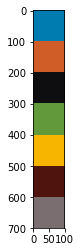

In [319]:
plt.imshow(
    np.concatenate(
        [
            np.tensordot(np.ones((100, 100), dtype=np.uint8), color, axes=0)
            for color in np.concatenate((COLORS,np.array([avg_colors[19, 19]] + [avg_colors[10, 16]])), axis=0)
        ],
        axis=0))

In [320]:
avg_colors[19, 19]

array([80, 20, 14], dtype=uint8)

In [321]:
COLORS

array([[  0, 124, 176],
       [208,  93,  40],
       [ 14,  14,  16],
       [ 97, 153,  59],
       [247, 181,   0]], dtype=uint8)

In [20]:
from colormath.color_diff import delta_e_cie2000, delta_e_cmc 
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color

In [21]:
color1 = sRGBColor(*avg_colors[16, 19], is_upscaled=True)
lab_color1 = convert_color(color1, LabColor)
for i in range(5):
    color2 = sRGBColor(*COLORS[i], is_upscaled=True)
    lab_color2 = convert_color(color2, LabColor)
    print(delta_e_cmc(lab_color1, lab_color2))

IndexError: index 19 is out of bounds for axis 1 with size 14

In [324]:
color1

sRGBColor(rgb_r=0.53333333333333333,rgb_g=0.10980392156862745,rgb_b=0.054901960784313725)

In [325]:
avg_colors[5, 5]

array([138,  46,  31], dtype=uint8)

In [326]:
138 / 255

0.5411764705882353

# Projection transformation on images

In [31]:
files = glob.glob("imgs/*.png")
plans = [[LABELS[int(x_)] for x_ in x[5:8]] for x in files]

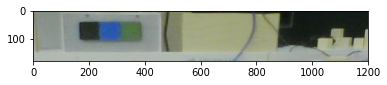

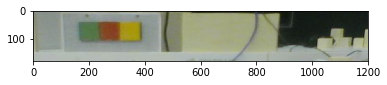

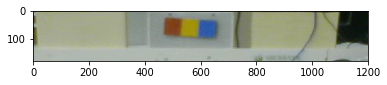

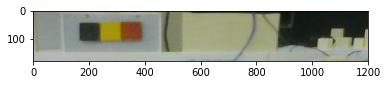

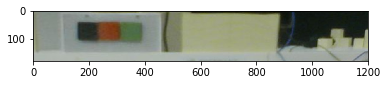

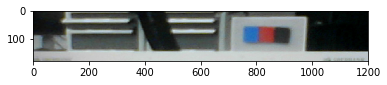

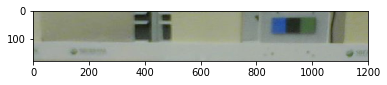

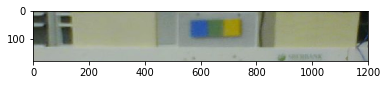

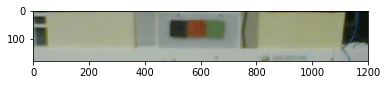

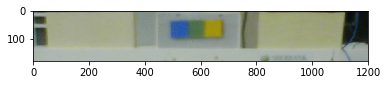

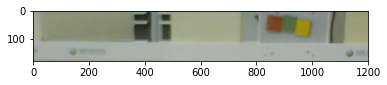

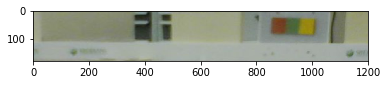

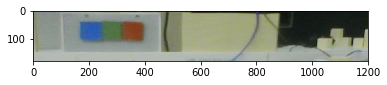

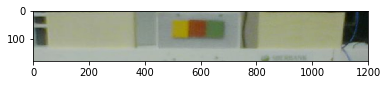

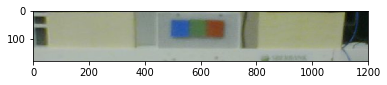

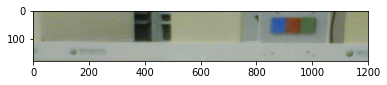

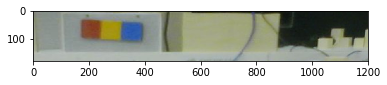

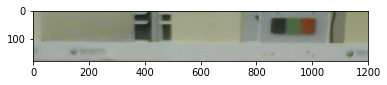

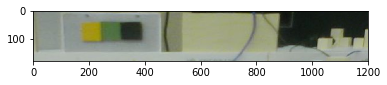

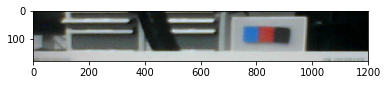

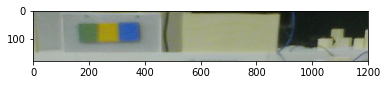

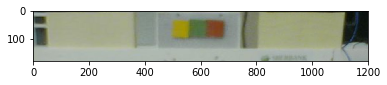

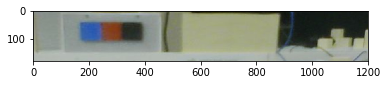

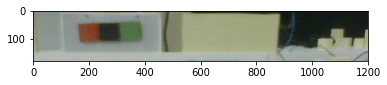

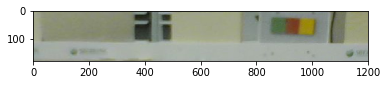

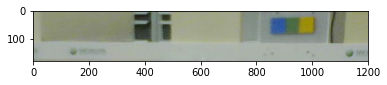

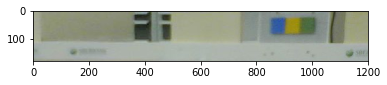

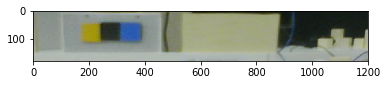

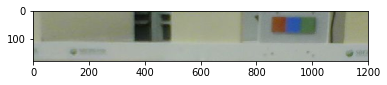

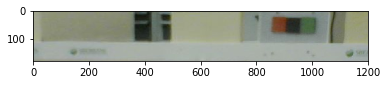

In [46]:
for file, plan in zip(files, plans):
    img_ = cv2.imread(file) 
    img_ = cv2.warpPerspective(img_, M, (w_border, h_border))
    plt.title = plan
    plt.imshow(cv2.cvtColor(img_, cv2.COLOR_RGB2BGR))
    plt.show()
    